In [1]:
# import commands
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow import keras
from tensorflow.keras import layers

In [2]:
# loading the train and test splits of mnist dataset
(ds_train, ds_test), ds_info = tfds.load(
    'mnist',
    split=['train', 'test'],
    shuffle_files=True,
    as_supervised=True,
    with_info=True,
)

In [3]:
# preparing train dataset
ds_train = ds_train.cache()
ds_train = ds_train.shuffle(ds_info.splits['train'].num_examples)
ds_train = ds_train.batch(128)
ds_train = ds_train.prefetch(tf.data.AUTOTUNE)

In [4]:
# preparing test dataset
ds_test = ds_test.batch(128)
ds_test = ds_test.cache()
ds_test = ds_test.prefetch(tf.data.AUTOTUNE)

In [5]:
# utility function to apply activations
def activation(z,func):
    return func(z)

In [6]:
# utility function for applying sigmoid activation
def sigmoid(z):
    exp = np.exp(z)
    g = (exp)/(1+exp)
    return g

In [7]:
# utility function for applying relu activation
def relu(z):
    max_ = np.max(z)
    z = np.where(z<0,0,z)
    return z

In [8]:
# utility function for derivative of sigmoid activation
def derivative_sigmoid(z):
    sigmoid_z = sigmoid(z)
    return sigmoid_z*(1-sigmoid_z)

In [9]:
# utility function for derivative of relu activation
def derivative_relu(z):
    z = np.where(z<0,0,1)
    return z

In [10]:
# utility function for applying softmax to an array
def softmax(z):
    sum_array = np.sum(np.exp(z),axis=1,keepdims = True)
    z = np.exp(z)/sum_array
    return z

In [11]:
# utility function to initialise all weights in OUR neural network
def initialize():
    for layer in range(1,len(hidden_layer_dim)):
        param_dict["W_"+str(layer)+""] = np.random.normal(0,1/hidden_layer_dim[layer-1],(hidden_layer_dim[layer].astype(int),hidden_layer_dim[layer-1].astype(int)))
        param_dict["B_"+str(layer)+""] = np.zeros((1,hidden_layer_dim[layer].astype(int)))

In [12]:
# utility function for 1 forward pass through OUR neural network
def forward(x):
    Z = x
    internal_dict["O_"+str(0)+""] = Z
    for layer in range(1,hidden_layers+2):
        W = np.array(param_dict["W_"+str(layer)])
        Z = np.matmul(Z,W.T) + np.array(param_dict["B_"+str(layer)])
        if(layer!=hidden_layers+1):
            Z = activation(Z,hidden_layer_activations[layer-1])
        internal_dict["O_"+str(layer)+""] = Z
    preds = softmax(Z)
    return preds

In [13]:
# utility function to implement cross entropy loss
def cross_entropy(preds,truths):
    preds = np.multiply(preds,truths)
    logs = np.where(preds!=0,-np.log(preds),0)
    loss = np.sum(logs)/batch_size
    return loss

In [14]:
# utility function for 1 backward propagation through OUR neural network
def backprop(preds,truths):
    truths = label2array(truths)
    loss = cross_entropy(preds,truths)
    loss_array.append(loss)
    delEdelO = preds
    delEdelO = np.where(truths==1,delEdelO-1,delEdelO)
    delEdelI_ll = delEdelO
    
    delEdelI_ll = np.where(delEdelI_ll>1,1,delEdelI_ll)
    delEdelI_ll = np.where(delEdelI_ll<-1,-1,delEdelI_ll)

    internal_dict["D_"+str(hidden_layers+1)+""] = delEdelI_ll
    prev_outputs = np.array([np.array(internal_dict["O_"+str(hidden_layers)+""]).T for i in range(hidden_layer_dim[-1].astype(int))])
    delEdelI_lls = np.array([delEdelI_ll for i in range(hidden_layer_dim[-2].astype(int))]).T
    delEdelI_lls = np.array(delEdelI_lls).transpose(0,2,1)

    delEdelW = np.sum(np.multiply(delEdelI_lls,prev_outputs),axis=2)/batch_size
    W = param_dict["W_"+str(hidden_layers+1)+""]
    W = W - (delEdelW) * learning_rate
    param_dict["W_"+str(hidden_layers+1)+""] = W
    
    B = param_dict["B_"+str(hidden_layers+1)+""]
    B = B - (np.sum(delEdelI_ll,axis=0)/batch_size) * learning_rate
    param_dict["B_"+str(hidden_layers+1)+""] = B

    for layer in range(hidden_layers,0,-1):
        delta_next = internal_dict["D_"+str(layer+1)+""]#.reshape((-1,-1,1))
        delta_next = np.array([delta_next for i in range(hidden_layer_dim[layer].astype(int))]).transpose(2,0,1)
        W = np.array(param_dict["W_"+str(layer+1)])
        W = np.array([W for i in range(batch_size)]).transpose(1,2,0)
        intermediate = np.multiply(delta_next,W)
        
        W = np.array(param_dict["W_"+str(layer)])
        Z = internal_dict["O_"+str(layer-1)+""]
        Z = np.matmul(Z,W.T) + np.array(param_dict["B_"+str(layer)])

        delOdelI = eval("derivative_"+str(hidden_layer_activations[layer-1].__name__)+"(Z)")
        delOdelI = np.array([delOdelI for i in range(hidden_layer_dim[layer+1].astype(int))]).transpose(0,2,1)
        delta = np.sum(np.multiply(delOdelI,intermediate),axis=0).T
        delta = np.where(delta>1,1,delta)
        delta = np.where(delta<-1,-1,delta)
        internal_dict["D_"+str(layer)+""] = delta
        
        prev_outputs = np.array([np.array(internal_dict["O_"+str(layer-1)+""]).T for i in range(hidden_layer_dim[layer].astype(int))])
        delEdelI_lls = np.array([delta for i in range(hidden_layer_dim[layer-1].astype(int))]).T
        delEdelI_lls = np.array(delEdelI_lls).transpose(0,2,1)
        delEdelW = np.sum(np.multiply(delEdelI_lls,prev_outputs),axis=2)/batch_size
    
        W = W - delEdelW * learning_rate
        param_dict["W_"+str(layer)+""] = W

        B = param_dict["B_"+str(layer)+""]
        B = B - (np.sum(delta,axis=0)/batch_size) * learning_rate
        param_dict["B_"+str(layer)+""] = B
        
    return 

In [15]:
# utility function to convert label into one hot vector
def label2array(label):
    label.numpy().reshape((-1,1))
    y=np.zeros((batch_size,10))
    for i in range(batch_size):
        y[i][label[i]]=1
    return y

In [16]:
# utility function for accuracy of a batch
def batch_accuracy(preds,truths):
    preds = np.argmax(preds,axis=1)
    preds = np.where(preds==truths,1,0)
    batch_acc = np.sum(preds)/len(preds)
    return batch_acc

In [17]:
# utility function for testing accuracy of OUR MODEL on test dataset
def test_accuracy():
    sum=0
    counter=0
    for elem in ds_test:
        counter = counter+1
        images,labels = elem
        images = images.numpy().reshape((images.numpy().shape[0],-1))

        preds = forward(images)
        sum = sum + batch_accuracy(preds,labels)
    print(sum/counter)

In [18]:
# utility function for testing accuracy of TF MODEL on test dataset
def model_accuracy():
    sum=0
    counter=0
    for elem in ds_test:
        counter = counter+1
        images,labels = elem
        images = images.numpy()

        preds = model(images)
        sum = sum + batch_accuracy(preds,labels)
    print(sum/counter)

In [19]:
# hyperparameters for training OUR neural network
epochs = 3
batch_size=128
learning_rate = 0.00001
input_dim = 28*28
hidden_layers = 1
hidden_layer_dimensions = [128] # comma separated information about the hidden layer dimensions
hidden_layer_activations = [relu] # comma separated information about the hidden layer activations
output_nodes = 10

In [20]:
hidden_layer_dim = np.zeros(hidden_layers+2,)
hidden_layer_dim[0] = input_dim
hidden_layer_dim[-1] = output_nodes
hidden_layer_dim[1:-1] = np.array(hidden_layer_dimensions).astype(int)

In [21]:
print(hidden_layer_dim)

[784. 128.  10.]


In [22]:
# itiliasing the dictionaries and all trainable parameters
param_dict = {}
internal_dict = {}
loss_array = []
initialize()

In [23]:
# Training OUR neural network
for epoch in range(epochs):
    counter=0
    for elem in ds_train:
        counter = counter+1
        internal_dict = {}
        images,labels = elem
        images = images.numpy().reshape((images.numpy().shape[0],-1))

        preds = forward(images)
        try:
            backprop(preds,labels)
        except:
            continue

/home/tfjuror/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log
  after removing the cwd from sys.path.


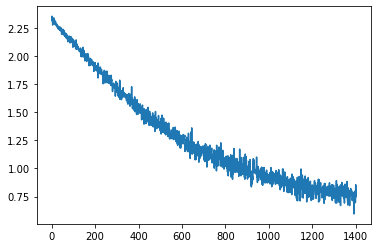

In [24]:
plt.plot(loss_array)
plt.show()

In [25]:
# The accuracy of our trained model on the test dataset
test_accuracy()

0.8574960443037974


In [26]:
# defining the same neural network using TF package
model = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(28, 28)),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(10)
])

In [27]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 128)               100480    
                                                                 
 dense_1 (Dense)             (None, 10)                1290      
                                                                 
Total params: 101,770
Trainable params: 101,770
Non-trainable params: 0
_________________________________________________________________


In [28]:
model.compile(
    optimizer=tf.keras.optimizers.SGD(0.0001),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy()],
)

In [29]:
model.fit(
    ds_train,
    epochs=3,
    validation_data=ds_test,
    verbose=1
)

Epoch 1/3
469/469 [==============================] - 2s 2ms/step - loss: 11.6968 - sparse_categorical_accuracy: 0.7519 - val_loss: 5.4367 - val_sparse_categorical_accuracy: 0.8426
Epoch 2/3
469/469 [==============================] - 1s 2ms/step - loss: 4.4650 - sparse_categorical_accuracy: 0.8588 - val_loss: 3.8836 - val_sparse_categorical_accuracy: 0.8696
Epoch 3/3
469/469 [==============================] - 1s 2ms/step - loss: 3.2864 - sparse_categorical_accuracy: 0.8801 - val_loss: 3.1174 - val_sparse_categorical_accuracy: 0.8847


In [30]:
# The accuracy of the TF trained model on the test dataset
model_accuracy()

0.8852848101265823
